In [1]:
!rm -rf *
!gdown --id 1mlgDfPbb7GQ32zhBEZ6IkPY1YwwlVxVW
!unzip ml-100k.zip
!gdown --id 11xsjOjSV_oc9SXjD5CHh1bE8TwA81Tmv
!unzip data.zip

Downloading...
From: https://drive.google.com/uc?id=1mlgDfPbb7GQ32zhBEZ6IkPY1YwwlVxVW
To: /content/ml-100k.zip
100% 4.92M/4.92M [00:00<00:00, 112MB/s]
Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  infla

In [2]:
import pandas as pd
import json
import numpy as np

def json2df(path):
    data = json.load(open(path,"r"))
    df = pd.DataFrame.from_dict(data)
    df = df.rename(columns={'users': 'user_id', 'items': 'item_id'})
    df.user_id= df.user_id.astype(np.int64)
    df.item_id= df.item_id.astype(np.int64)
    df.rating = df.rating.astype(np.float32)
    return df


In [3]:
train = json2df("data/100k/train_100k.json")
test = json2df("data/100k/test_100k.json")

In [4]:
movies = pd.read_csv('ml-100k/u.item', sep='|', usecols=[0].append(range(5,24)), encoding='latin-1',  header=None) 
movies.rename( columns={0:'item_id'}, inplace=True )
movies['genre_vec'] = movies[range(5,24)].values.tolist()

cols = range(1,24)
movies.drop(movies.columns[cols],axis=1,inplace=True)


In [5]:
train = train.merge(movies, how='inner', on='item_id')
test = test.merge(movies, how='inner', on='item_id')
dataset= train.append(test, ignore_index=True)
dataset

,user_id,item_id,rating,genre_vec
0,1,1,5.0,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,1,4.0,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,6,1,4.0,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,13,1,3.0,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,16,1,5.0,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
89995,437,1121,5.0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ..."
89996,437,1262,3.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
89997,445,1591,4.0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
89998,448,1294,1.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
import keras
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, concatenate, Dropout
from IPython.display import SVG

from keras.utils.vis_utils import model_to_dot
n_users, n_movies = dataset.user_id.max(), dataset.item_id.max()
n_latent_factors = 12

In [7]:
import keras.backend as K

def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

genre_input = keras.layers.Input(shape=[19],name='Genre')
genre_embedding = keras.layers.Embedding(19, 19, name='Genre-Embedding')(genre_input)
genre_vec = keras.layers.Flatten(name='FlattenGenres')(genre_embedding)

concat = concatenate([movie_vec, genre_vec])
dense_1 = Dense(12, name ='Fully-Connected1', activation='relu')(concat)

concat2=  concatenate([dense_1, user_vec])
dense_2 = Dense(16, name ='Fully-Connected2', activation='relu')(concat2)
dense_3 = Dense(12, name ='Fully-Connected3', activation='relu')(dense_2)
prod = Dense(1, name ='Fully-Connected4', activation='relu')(dense_3)
model = keras.Model([user_input, movie_input, genre_input], prod)

        
model.compile(optimizer= 'adam', loss= rmse, metrics=['mean_absolute_error', 'mse', rmse])

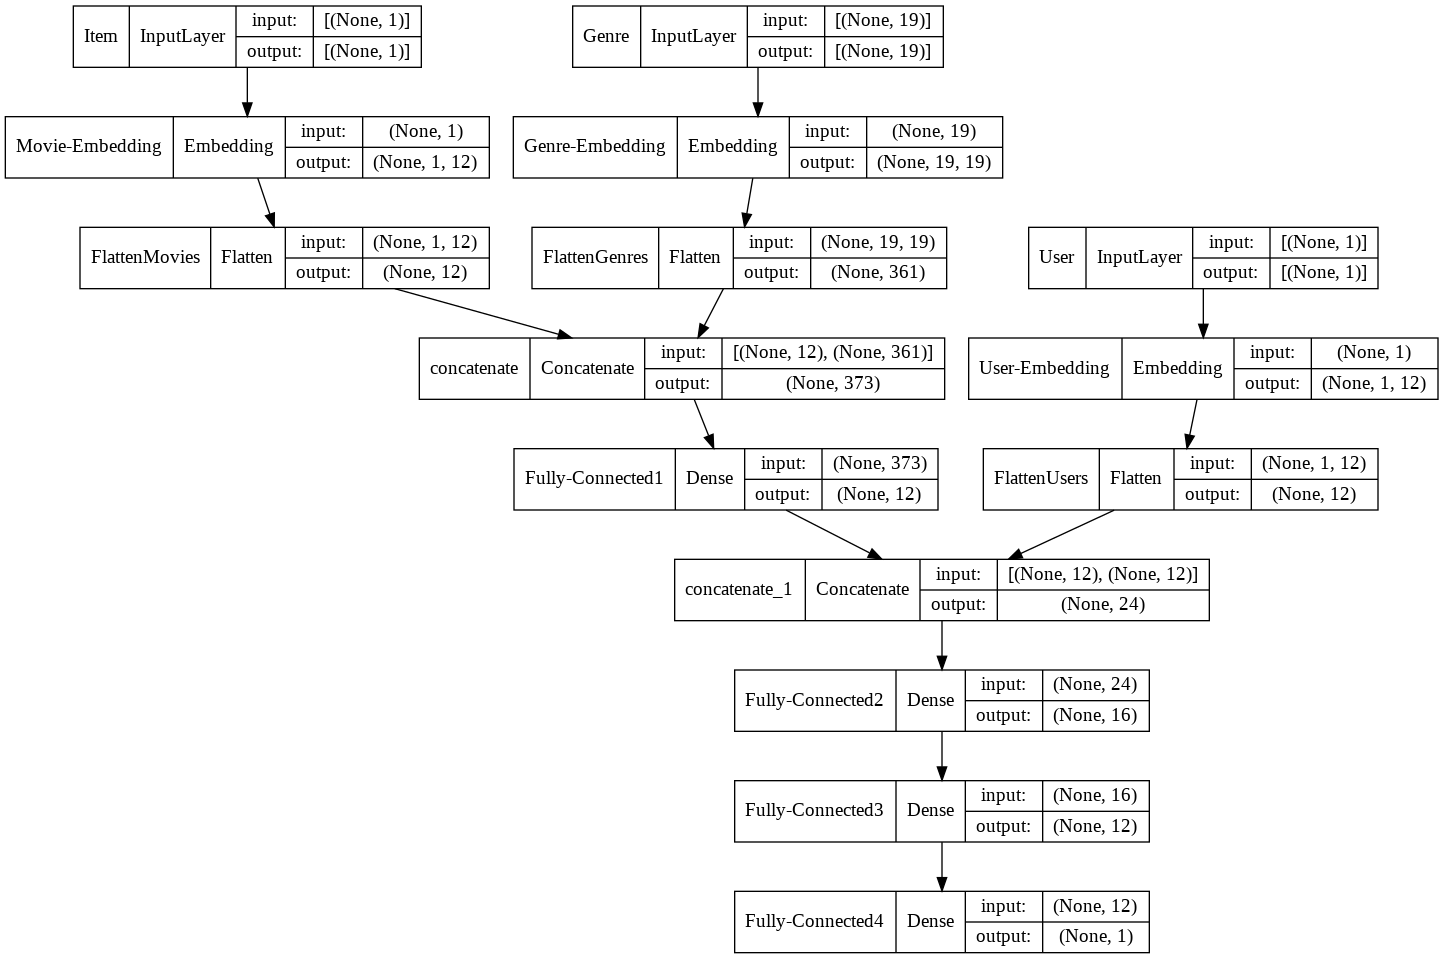

In [8]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Genre (InputLayer)             [(None, 19)]         0           []                               
                                                                                                  
 Movie-Embedding (Embedding)    (None, 1, 12)        20196       ['Item[0][0]']                   
                                                                                                  
 Genre-Embedding (Embedding)    (None, 19, 19)       361         ['Genre[0][0]']                  
                                                                                              

In [10]:
genre = np.asarray([np.asarray(row, dtype=float) for row in train.genre_vec], dtype=float)
traindata = {
  "User": train.user_id,
  "Item": train.item_id,
  "Genre": genre
}
history = model.fit(traindata, train.rating, epochs=15, verbose=1)

Epoch 1/15
2500/2500 [==============================] - 7s 3ms/step - loss: 1.0110 - mean_absolute_error: 0.8202 - mse: 1.1172 - rmse: 1.0110
Epoch 2/15
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9325 - mean_absolute_error: 0.7441 - mse: 0.8854 - rmse: 0.9325
Epoch 3/15
2500/2500 [==============================] - 6s 3ms/step - loss: 0.9269 - mean_absolute_error: 0.7399 - mse: 0.8751 - rmse: 0.9269
Epoch 4/15
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9247 - mean_absolute_error: 0.7372 - mse: 0.8710 - rmse: 0.9247
Epoch 5/15
2500/2500 [==============================] - 6s 3ms/step - loss: 0.9221 - mean_absolute_error: 0.7346 - mse: 0.8653 - rmse: 0.9221
Epoch 6/15
2500/2500 [==============================] - 6s 3ms/step - loss: 0.9210 - mean_absolute_error: 0.7340 - mse: 0.8639 - rmse: 0.9210
Epoch 7/15
2500/2500 [==============================] - 6s 2ms/step - loss: 0.9174 - mean_absolute_error: 0.7307 - mse: 0.8572 - rmse: 0.9174
Epoch 

In [11]:
genre = np.asarray([np.asarray(row, dtype=float) for row in test.genre_vec], dtype=float)
testData =  {
  "User": test.user_id,
  "Item": test.item_id,
  "Genre": genre
}
score = model.evaluate(testData, test.rating, batch_size=test.user_id.size, verbose=1)

1/1 [==============================] - 0s 242ms/step - loss: 0.9416 - mean_absolute_error: 0.7415 - mse: 0.8867 - rmse: 0.9416
